# How to train a cross-modal VAE to translate data modalities `x-modalix`

## Example: From cancer gene expression signature to MNIST digit images

As a showcase for data modality translation by `x-modalix`, we will use cancer gene expression from TCGA as in previous notebooks in combination with handwritten digits from the [MNIST data set](https://keras.io/api/datasets/mnist/).  
Our goal is to translate the gene expression signature of five selected cancer subtypes to images of digits, where each cancer subtype class is assigned to a digit between 0-4:  

<img src="https://raw.githubusercontent.com/jan-forest/autoencodix/729f3e8172a722e7c3681298719d9d4b59e313d9/images/xmodalix_scheme.svg" alt="ontix-ontologies" width="1200"/>

In practice those images can be histopathological images or any other data modality. Before we show data preparation and `x-modalix` training, some background to the basic idea of a cross-modal VAE as proposed by [Yang & Uhler](https://arxiv.org/abs/1902.03515). 

### Key ideas behind cross-modal VAE's

The underlying models are two separate VAE's for each data modality which are trained in parallel. However, their latent spaces are very closely aligned in a way that data modalities can hardly be discriminated, but sample variation is kept.  
By this alignment one can easily translate between data modalities. To get an aligned latent space, the loss function to train both VAE's is extended by the following terms and ideas:

- *Adversarial* loss term: in parallel to both VAE a third neural network (latent space classifier) is trained to discriminate the latent space embeddings of both data modalities. Analogously to a GAN, the inverse loss of this latent space classifier is used as loss term in addition to the normal VAE loss function to enforce an alignment of latent spaces. 
- *Paired* loss term: Latent space alignment is further enforced by minimizing the distance between samples with paired measurements of each data modality. In our current implementation, all samples must have paired measurements to use the paired loss. 
- *Class-based* loss term: If one does not have paired measured samples, a semi-supervised training loss term can be used, which minimizes distance among each class of samples. In our example this will be the five cancer subtypes.

## Make sure you are using the correct kernel 
You probably have already selected **autoencodix-ga-kernel** (visible in the top right corner of this notebook) as instructed in `install-kernel-script.ipynb`, if not:

Select the **autoencodix-ga-kernel** in the Top Menu -> Kernel -> Change Kernel"

If it is not listed, reload the browser and try again.

## Test Notebook Setup

Firstly, we need to ensure we are working in the correct directory. The next cell ensures this, all other cells will assume you are in `/data/horse/ws/<YOURUSERNAME>-AE-ws/autoencodix/Tutorials` and will change directories based on this location if needed.

In [14]:
import os
path = os.path.expandvars("$HOME/horse/$USER-AE-ws/autoencodix/Tutorials")
os.chdir(path)

cur_dir = os.getcwd()
print(f"Current working directory: {cur_dir}")

Current working directory: /data/horse/ws/majo158f-AE-ws/autoencodix/Tutorials


### Set-up your input data for `x-modalix`

The set-up of non-image data is described in the [Basics_Autoencodix.ipynb](Basics_Autoencodix.ipynb) and we provide for this tutorial the pre-formatted files.  
To be able to work with image-data in `AUTOENCODIX`, one needs to provide the folder (1) with all images in a common format like `tiff`, `png` or `jpeg` and a sample mapping file (2) to map image data of sample to gene expression sample names.  
Let`s do this for our example:

In [15]:
## For platform independence we will do this in Python
## Of course, you can do this also via bash or manually
import os
import urllib.request
import zipfile

# (1) Get into root directory
cur_dir = os.getcwd()
rootpath = os.path.expandvars("$HOME/horse/$USER-AE-ws/autoencodix/")
os.chdir(rootpath)
cur_dir = os.getcwd()
print(f"Current working directory: {cur_dir}")


# (2) Download and extract the data in directory data/raw
url = "https://cloud.scadsai.uni-leipzig.de/index.php/s/rSMzzJLsiwDRWgW/download/XModalix-Tut-data.zip"
data_dir = os.path.join("data", "raw")

urlretrieve = urllib.request.urlretrieve(url, "XModalix-Tut-data.zip")
print(f"Downloaded data to: {urlretrieve[0]}")
with zipfile.ZipFile("XModalix-Tut-data.zip", 'r') as zip_ref:
	zip_ref.extractall(data_dir)
print(f"Extracted data to: {data_dir}")
# (3) Remove the zip file
os.remove("XModalix-Tut-data.zip")

Current working directory: /data/horse/ws/majo158f-AE-ws/autoencodix
Downloaded data to: XModalix-Tut-data.zip
Extracted data to: data/raw


Let's have a look at the files and their required format.  
(1) Gene expression data: `combined_rnasew_formatted.parquet` with samples as rows and features (genes) as columns as described in [Basics_Autoencodix.ipynb](Basics_Autoencodix.ipynb)  
(2) Images `data/raw/images`  
(3) Sample mapping file  

In [9]:
# (2) MNIST images
!ls data/raw/images/tcga_fake/ | sort -n | tail -n 3

!echo "Number of images with digit 0 (breast cancer)"
!ls data/raw/images/tcga_fake/*label_0.png | wc -l
!echo "Number of images with digit 1 (lung cancer)"
!ls data/raw/images/tcga_fake/*label_1.png | wc -l
!echo "Number of images with digit 2 (colorectal cancer)"
!ls data/raw/images/tcga_fake/*label_2.png | wc -l
!echo "Number of images with digit 3 (endometrial cancer)"
!ls data/raw/images/tcga_fake/*label_3.png | wc -l
!echo "Number of images with digit 4 (ovarian cancer)"
!ls data/raw/images/tcga_fake/*label_4.png | wc -l

3899_label_1.png
3900_label_1.png
3901_label_1.png
/data/horse/ws/majo158f-AE-ws/autoencodix
Number of images with digit 0 (breast cancer)
1084
Number of images with digit 1 (lung cancer)
1053
Number of images with digit 2 (colorectal cancer)
594
Number of images with digit 3 (endometrial cancer)
586
Number of images with digit 4 (ovarian cancer)
585


The sample mapping must have format with the first column (`"sample_ids"`) indicating the samples and the second column (`"img_paths"`) containing the image file name:

In [4]:
# (3) Mapping images to TCGA samples
!head -n5 data/raw/images/tcga_fake/tcga_mappings.txt 


sample_ids	img_paths	extra_class_labels
TCGA-05-4244-01	0_label_1.png	Non-Small Cell Lung Cancer
TCGA-05-4249-01	1_label_1.png	Non-Small Cell Lung Cancer
TCGA-05-4250-01	2_label_1.png	Non-Small Cell Lung Cancer
TCGA-05-4382-01	3_label_1.png	Non-Small Cell Lung Cancer


### Config definition
Now the input data is ready and we need to specifiy our config in the following way for our `x-modalix` which should translate `FROM` gene expression data `TO` MNIST images.

In [16]:
## We will use Python for config defintion, but you can write your own yaml-config with an editor
import yaml
cfg = dict()
# X-Modalix specific
cfg['MODEL_TYPE'] = "x-modalix" 
cfg["GAMMA"] = 10				# Weight hyperparameter for adversarial loss term
cfg["DELTA_PAIR"] = 10			# Weight hyperparameter for paired loss term
cfg["DELTA_CLASS"] = 10			# Weight hyperparameter for class-based loss term
cfg["CLASS_PARAM"] = "CANCER_TYPE"	# Class for which class-based loss is calculated (column in ANNO)
cfg["PRETRAIN_TARGET_MODALITY"] = "pretrain_image"	# We recommend to pretrain the image VAE
cfg["PRETRAIN_EPOCHS"] = 50	# Number of epochs for image pretraining
cfg["TRANSLATE"] = "RNA_to_IMG"	# Specification of translation direction

# DATA DEFINITIONS ------------------------------------------------------------
# -----------------------------------------------------------------------------
cfg["ROOT_IMAGE"] = "data/raw/images/tcga_fake/"	# Image folder

cfg['DATA_TYPE'] = dict()
# RNA
cfg['DATA_TYPE']['RNA'] = dict()
cfg['DATA_TYPE']['RNA']['SCALING'] = "Standard"	# We scale features by the standard scaler
cfg['DATA_TYPE']['RNA']['TYPE'] = "NUMERIC"
cfg['DATA_TYPE']['RNA']['FILTERING'] = "Var"	# We filter for feature with highest variance
cfg['DATA_TYPE']['RNA']['FILE_RAW'] = "combined_rnaseq_formatted.parquet"
# IMG
cfg['DATA_TYPE']['IMG'] = dict()
cfg['DATA_TYPE']['IMG']['SCALING'] = "Standard"
cfg['DATA_TYPE']['IMG']['TYPE'] = "IMG"			# Image data type
cfg['DATA_TYPE']['IMG']['WIDTH'] = 32				# Specification of image dimension
cfg['DATA_TYPE']['IMG']['HEIGHT'] = 32
cfg['DATA_TYPE']['IMG']['FILTERING'] = "Var"
cfg['DATA_TYPE']['IMG']['FILE_RAW'] = "tcga_mappings.txt" # Mapping file of sample to images
# Clinical Parameters for plotting
cfg['DATA_TYPE']['ANNO'] = dict()
cfg['DATA_TYPE']['ANNO']['TYPE'] = "ANNOTATION"
cfg['DATA_TYPE']['ANNO']['FILE_RAW'] = "combined_clin_formatted.parquet"
## Model and Training --------------------------------------------------------
# ----------------------------------------------------------------------------
# Reproducibility
cfg['FIX_RANDOMNESS'] = "all"
cfg['GLOBAL_SEED'] = 42
# Model
cfg['TRAIN_TYPE'] = "train" # simple training, no tuning
cfg['RECONSTR_LOSS'] = "MSE"	# loss function for reconstruction
cfg['VAE_LOSS'] = "KL"		# loss function distribution distance
cfg['BETA'] = 0.5			# weighting of VAE loss
cfg['K_FILTER'] = 1000		# Input features per data modality
cfg["LATENT_DIM_FIXED"] = 6	# Latent space dimension
# Training
cfg['EPOCHS'] = 250
cfg['LR_FIXED'] = 0.0005	# Learning rate
cfg['BATCH_SIZE'] = 512
# Prediction
cfg['PREDICT_SPLIT'] = "all"	# Embedding of all samples should be calculated in prediction
# EVALUATION and VISUALIZATION ------------------------------------------------
# -----------------------------------------------------------------------------
cfg['DIM_RED_METH'] = "UMAP"	# For 2D visualization when LATENT_DIM_FIXED>2
cfg['CLINIC_PARAM'] = [			# Parameters to colorize plots and perform embedding evaluation
				"CANCER_TYPE",
			]

## save config
with open("MNIST-Cancer_config.yaml", 'w') as file:
	yaml.dump(cfg, file)

### `X-modalix` training

In the same way as all other architectures we can start the `AUTOENCODIX` pipeline like this:

In [17]:
# For reproducibility we need to specifiy this CUBLA configuration:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

cur_dir = os.getcwd()
rootpath = os.path.expandvars("$HOME/horse/$USER-AE-ws/autoencodix/")
os.chdir(rootpath)
cur_dir = os.getcwd()
print(f"Current working directory: {cur_dir}")
!source venv-gallia/bin/activate
# Start AUTOENCODIX
!make visualize RUN_ID=MNIST-Cancer

env: CUBLAS_WORKSPACE_CONFIG=:16:8
Detected platform: Linux
Setting up directories and configuration for RUN_ID: MNIST-Cancer
✓ Configuration complete
python3 src/data/make_dataset.py MNIST-Cancer
2025-09-03 15:37:00,891 - src.utils.utils_basic - INFO - Unify sample ID list from data files
2025-09-03 15:37:05,058 - src.utils.utils_basic - INFO - Save sample split.
2025-09-03 15:37:05,423 - src.utils.utils_basic - INFO - Unified sample ID list has length 3230
2025-09-03 15:37:05,423 - src.utils.utils_basic - INFO - Make data set ANNO
2025-09-03 15:37:05,762 - src.utils.utils_basic - INFO - Save ANNOTATION without preprocessing
2025-09-03 15:37:06,221 - src.utils.utils_basic - INFO - Make data set RNA
2025-09-03 15:37:07,727 - src.utils.utils_basic - INFO - Select for samples and drop features with NA
2025-09-03 15:37:08,775 - src.utils.utils_basic - INFO - Filter data: RNA
2025-09-03 15:37:08,775 - src.utils.utils_basic - INFO - Filter by variance and exclude with no variance
2025-09-03

### Inspecting resulting `x-modalix` and translation capabilities

#### Loss term contributions
To check the training of our `x-modalix`, we can first check the loss curves and how the different loss terms contribute to the overall loss.

Loss curve of total loss and different loss terms


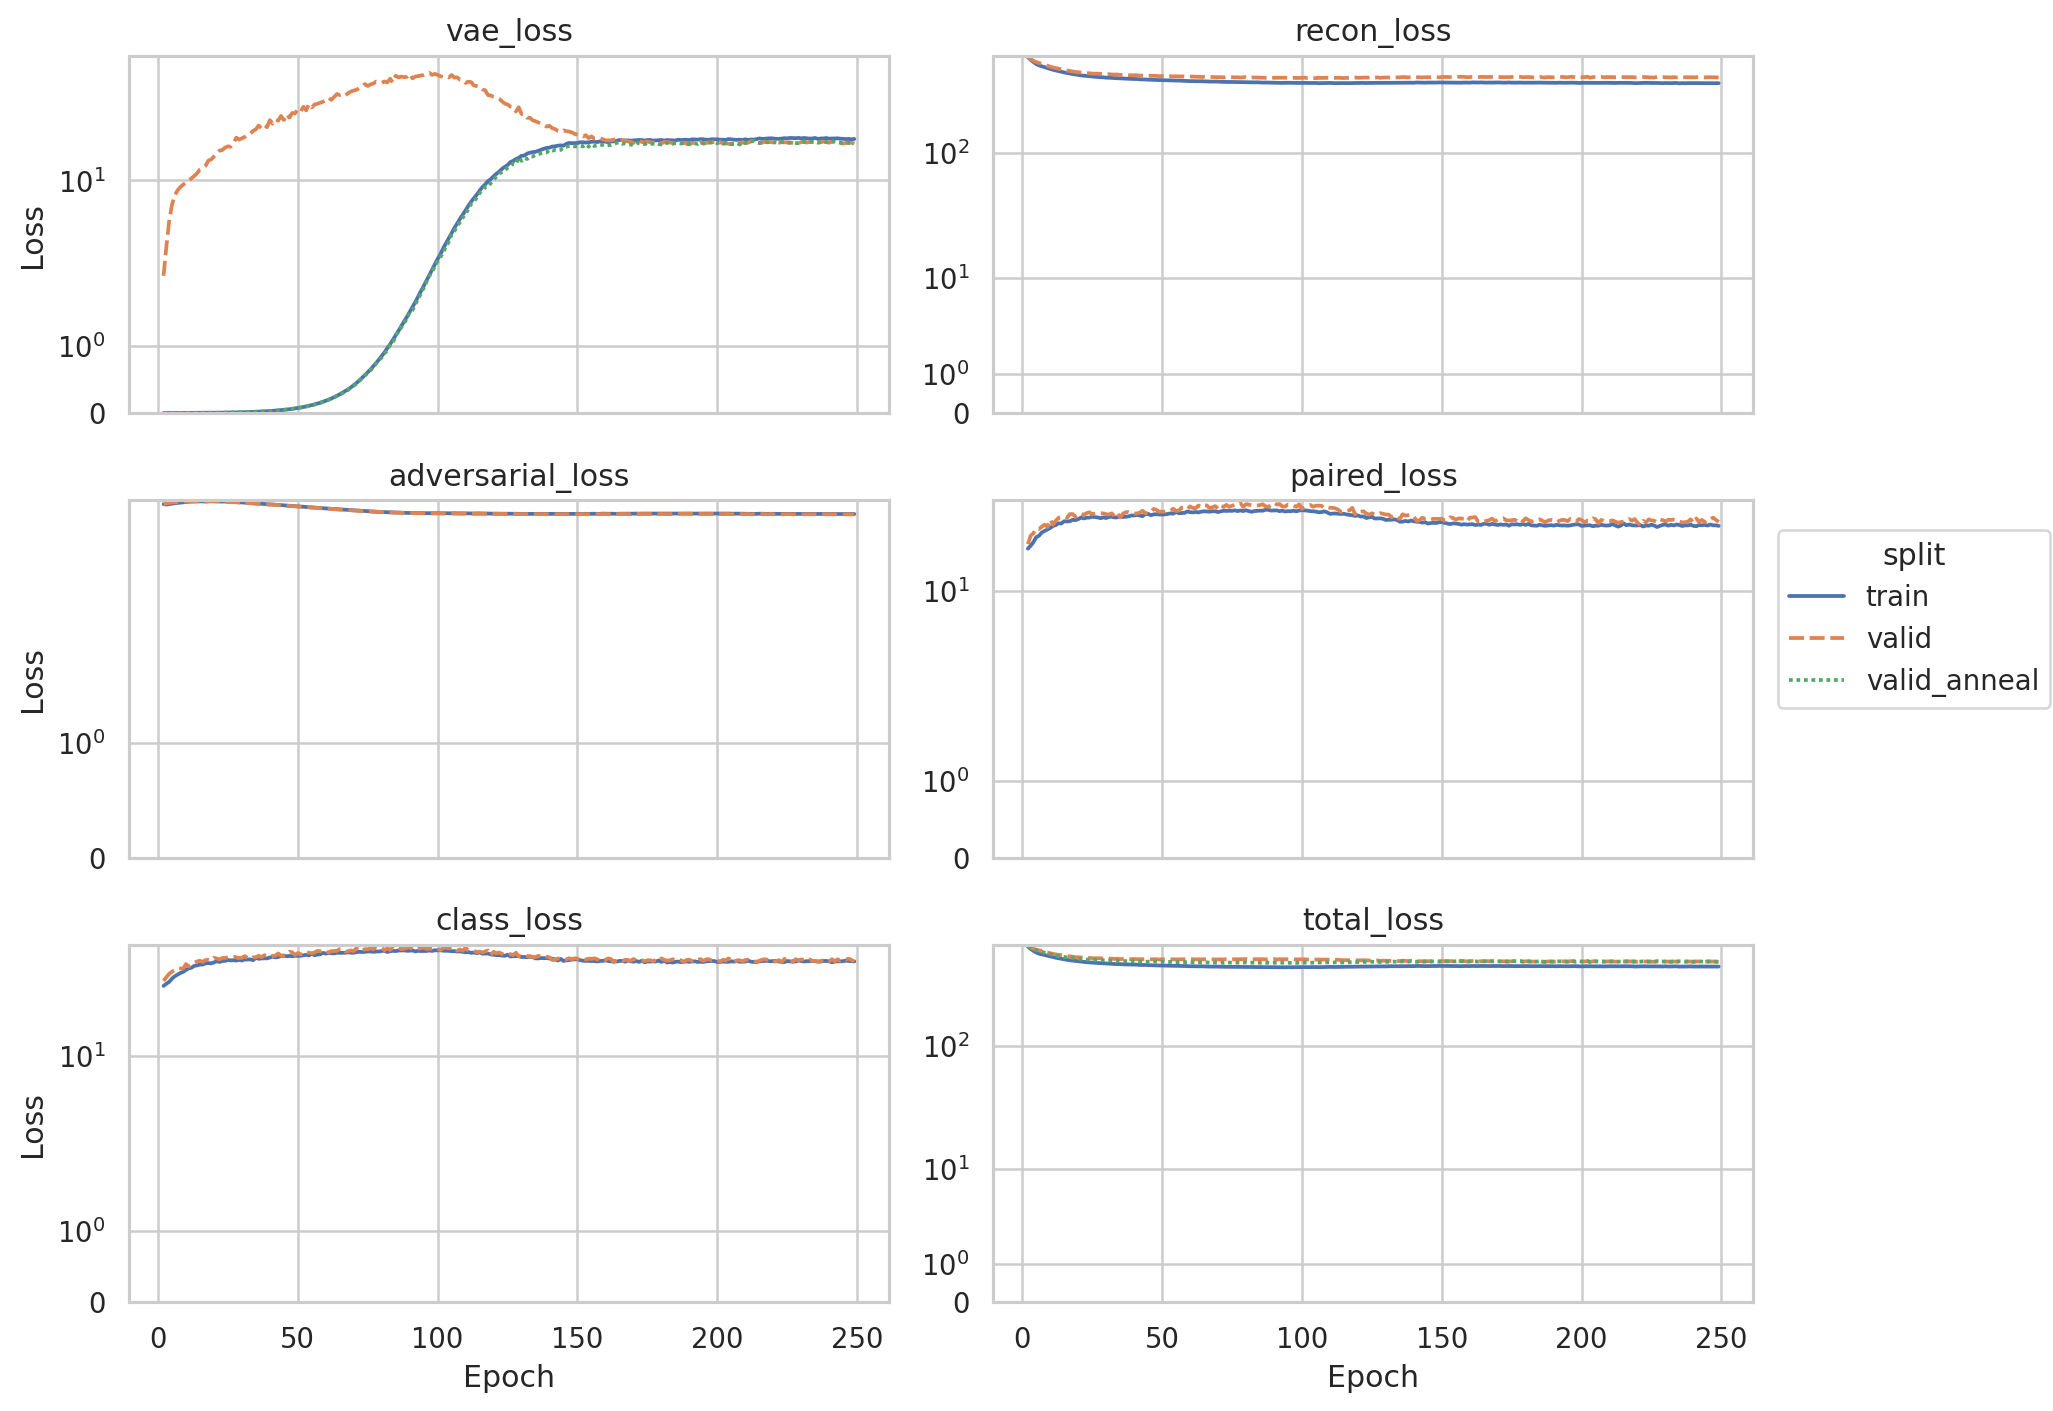

Loss term contribution over epochs to total loss


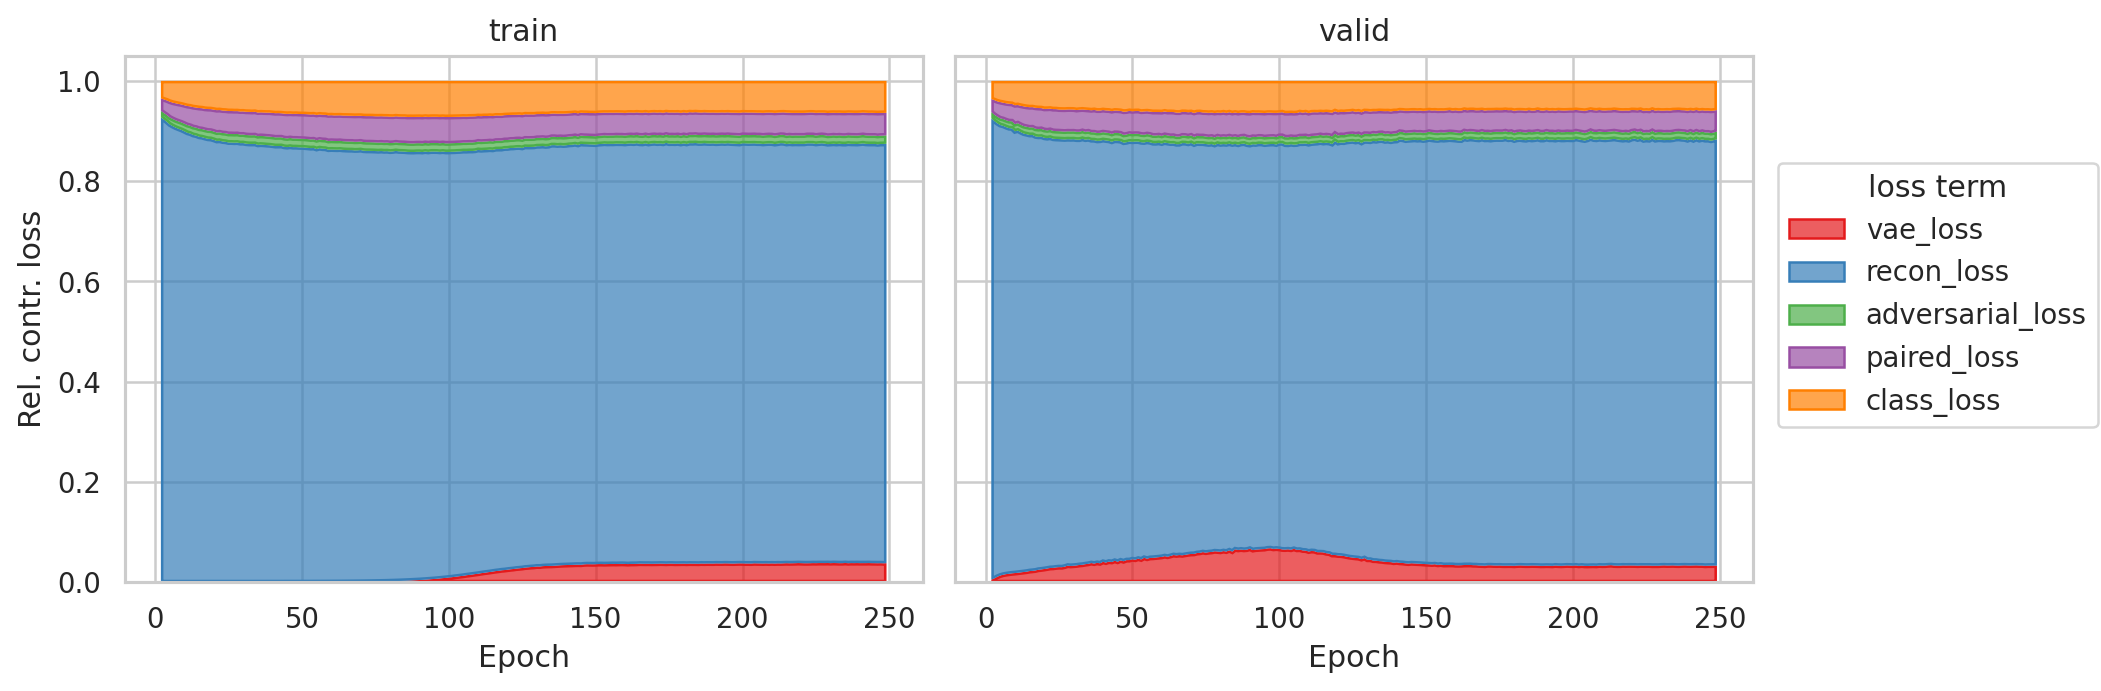

In [18]:
from IPython.display import Image
from IPython.display import display

loss_abs = Image(filename='reports/MNIST-Cancer/figures/loss_plot_absolute.png', width=600)
loss_rel = Image(filename='reports/MNIST-Cancer/figures/loss_plot_relative.png', width=600)

print("Loss curve of total loss and different loss terms")
display(loss_abs)
print("Loss term contribution over epochs to total loss")
display(loss_rel)

The loss term contribution plot can be crucial to find the correct weighting in the loss function and setting the corresponding parmeters `BETA`, `GAMMA`, `DELTA_PAIR` and `DELTA_CLASS`.  
As a starting point we recommend that reconstruction loss should be the majority (>40%) in total loss. VAE-loss controlled by `BETA` should set with care and is often below 5%. The remaining loss terms must be set according to the quality of the latent space alignment as we can inspect by the following plot: 

2D latent space representation of both aligned VAE (FROM: gene expression, TO: MNIST)


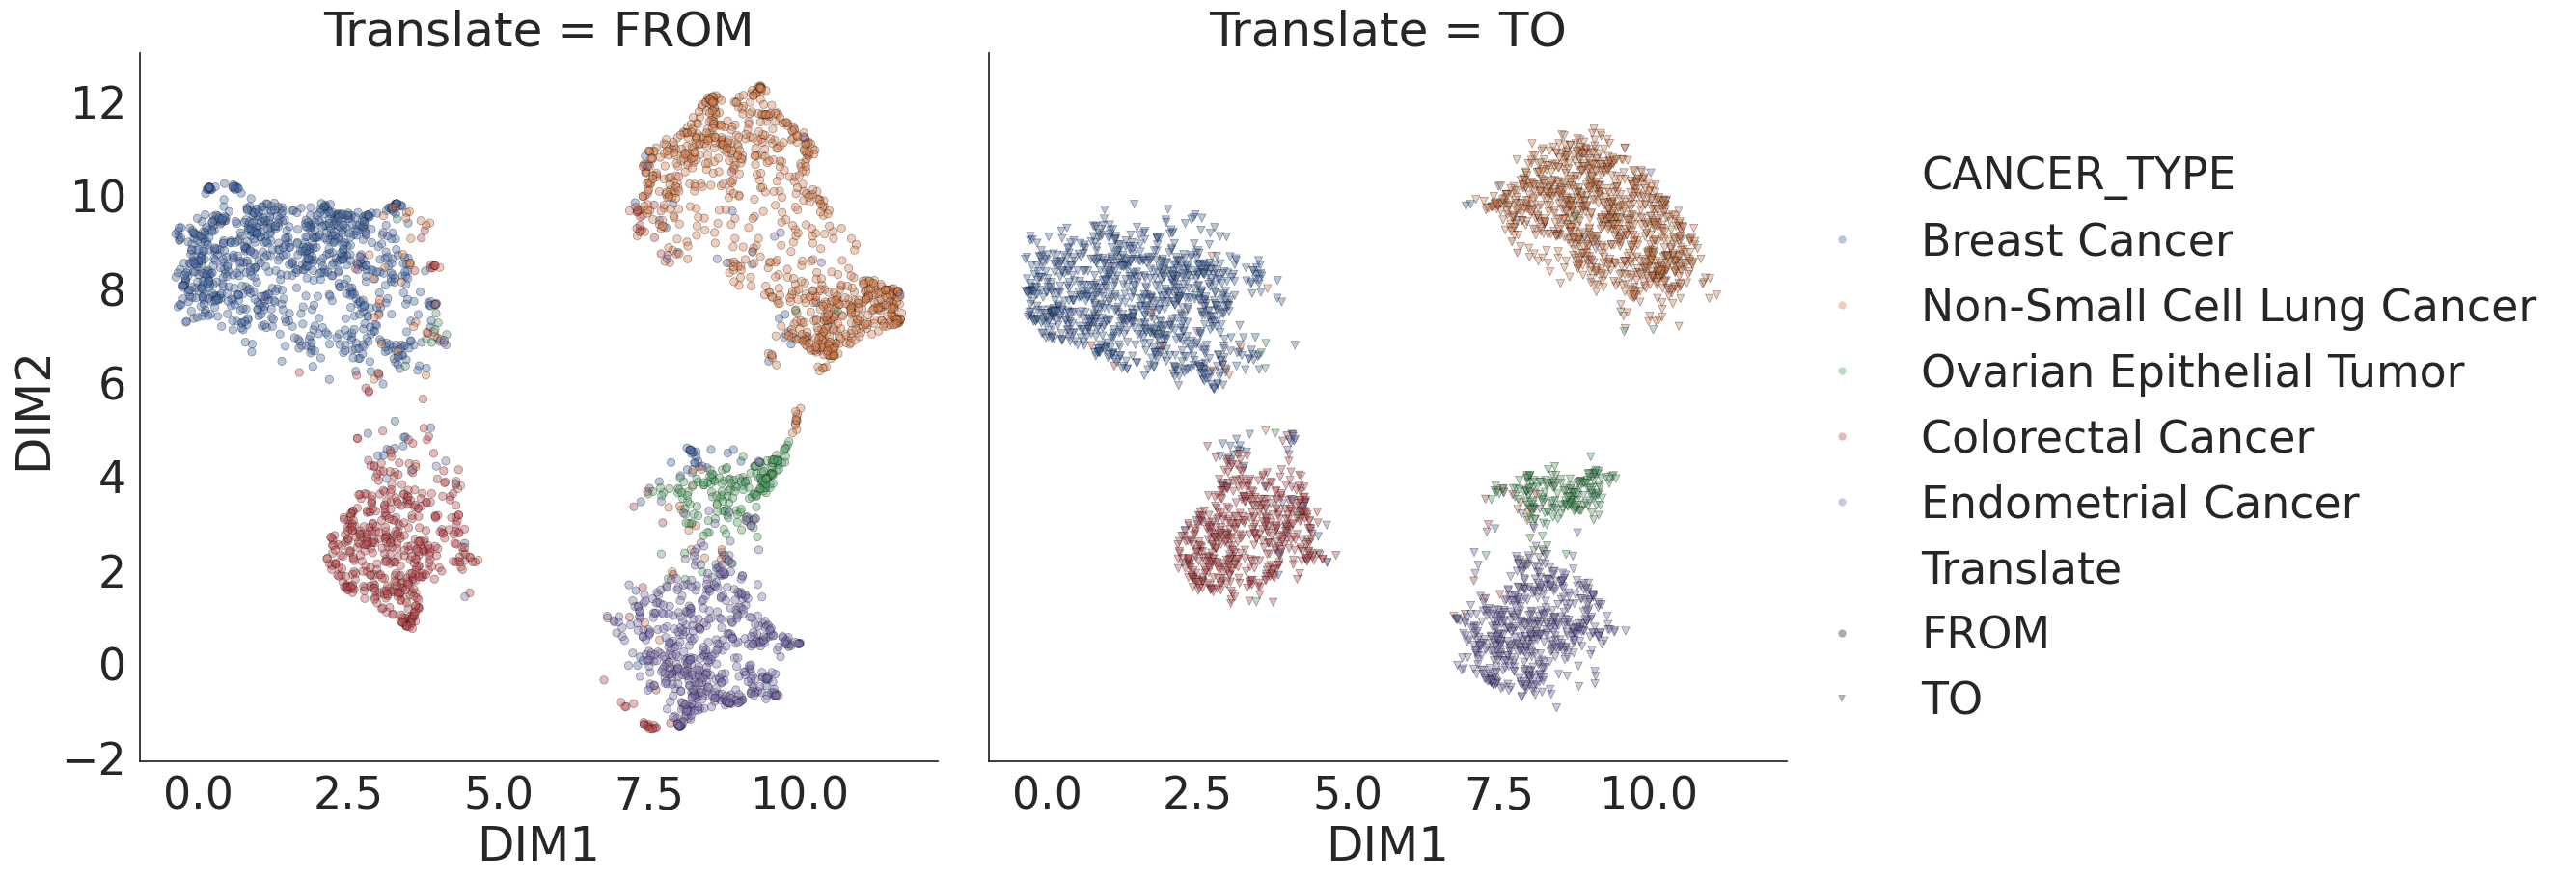

In [19]:
latent_cancer = Image(filename='reports/MNIST-Cancer/figures/latent2D_Aligned_CANCER_TYPE.png', width=1200)

print("2D latent space representation of both aligned VAE (FROM: gene expression, TO: MNIST)")
display(latent_cancer)


We can see that both data modalities are nicely aligned according to the five cancer types. This is the prerequisite to be able to translate the gene expression signature (`FROM`) to the respective MNIST digit (`TO`). 

Let's see how good the translation is:

Generated images from gene expression signatures:


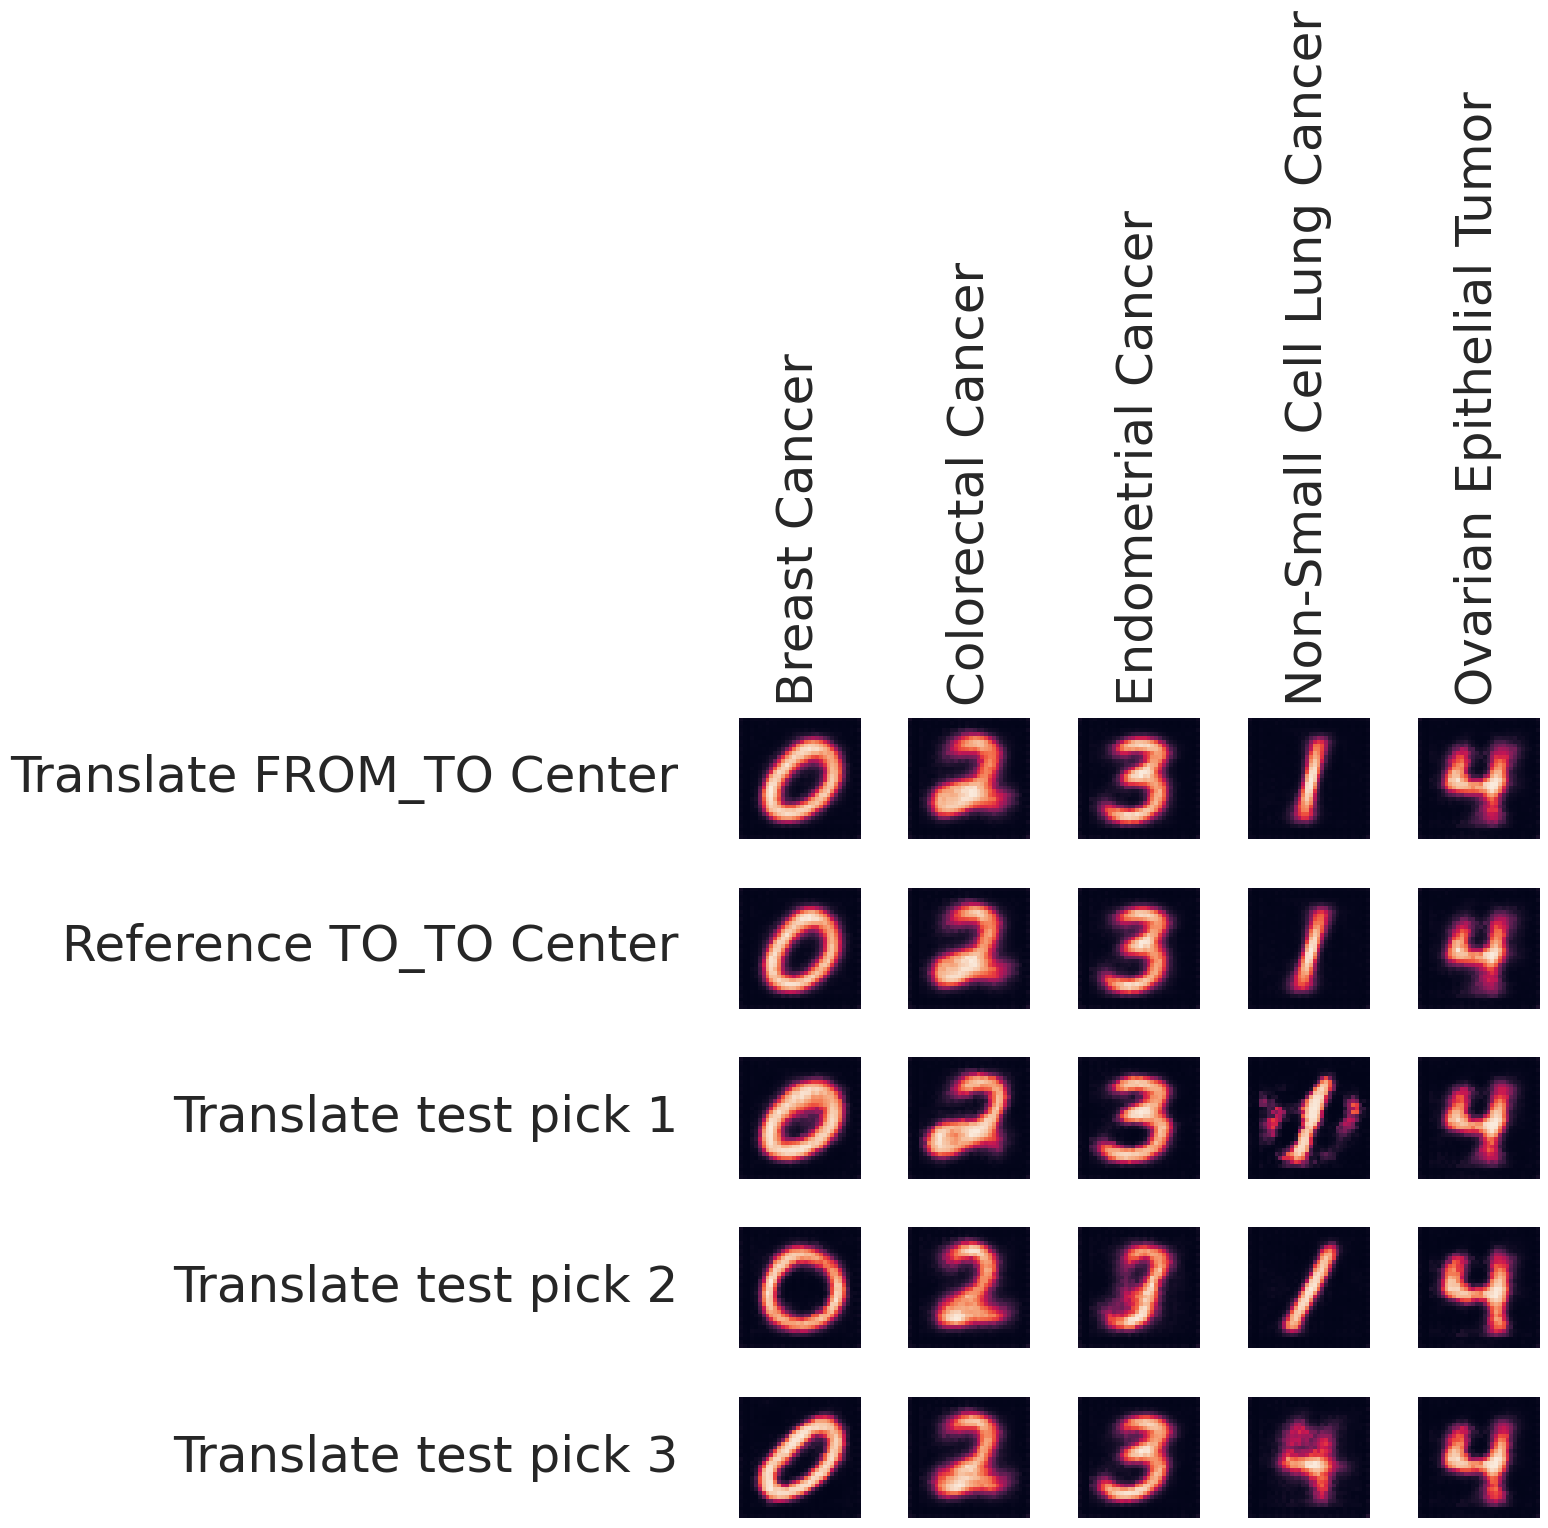

In [20]:
translation_grid = Image(filename='reports/MNIST-Cancer/figures/translategrid_CANCER_TYPE.png', width=700)

print("Generated images from gene expression signatures:")
display(translation_grid)

In this grid we can see for each class (cancer type) the translation of gene expression to digit for the following cases:
- `FROM center`: this is the average gene expression signature based on RNA-VAE embeddings within the class
- `TO center`: this is the average digit signature based on IMG-VAE embeddings within the class
- `FROM_TO test pick`: these are randomly chosen samples from the test-split with translation from gene expression to digit

Based on this grid we can see that digits can be nicely reconstructed by using the IMG-VAE decoder when given the embeddings from the RNA-VAE encoder. Hence, gene expression is translated correctly to digit of the cancer type.